In [9]:
# Librerías importadas
import numpy as np
import pandas as pd
import configparser
import psycopg2
import os
from datetime import datetime
import math
np.seterr(all="ignore")
pd.options.mode.chained_assignment = None 
# Librerías propias
from PSO import LBestPSO
from utils import GPD_Acum,A_2,Test_P_01,Datos_Indep,Convergencia_AD
# Traigo los datos
Data = pd.read_csv('Datos.csv') 
Finales = []
for mes in ["01","02","03","04","05","06","07","08","09","10","11","12"]:
    Aux = []
    print("El mes {}".format(mes))
    Datos = Data[Data["fecha"].str.contains("-{}-".format(mes), regex=False)]

    # Agrupamos los datos por fecha y nos quedamos con el máximo
    group = Datos.groupby(['fecha'], as_index=False)
    Datos = group.max()

    # Lo ordenamos por temperatura
    Datos.sort_values(by=['temint'],inplace=True)


    # Nos quedamos con el décimo más alto de temperaturas
    Datos = Datos.iloc[-1*len(Datos)//10:]

    # Volvemos a ordenar por fecha
    Datos.sort_index(inplace=True)

    # Convierto la columna fecha en string
    Datos = Datos.astype({'fecha':'string'})

    # Construyo el umbral inicial
    Minimo = min(Datos["temint"])
    Maximo = max(Datos["temint"])

    # Le resto el mínimo
    Datos['temint'] = Datos['temint'] - Minimo


    # Me quedo con los datos cuyos excedentes son mayores que 0
    Datos = Datos[Datos['temint']>0]

    # Calculo  la constante de actualización
    inter = round((Maximo - Minimo)/100,2)

    # Ejecuto el algoritmo para setear el umbral
    gamma,sigma,Threshold_Intermedio = Convergencia_AD(Datos,Minimo,inter=inter,verb=False)

    Datos = Data[Data["fecha"].str.contains("-{}-".format(mes), regex=False)]
    
    # Volvemos a ordenar por fecha
    Datos.sort_index(inplace=True)
    # Agrupamos los datos por fecha y nos quedamos con el máximo
    group = Datos.groupby(['fecha'], as_index=False)
    Datos = group.max()
    # Separo los datos en 4 grupos de manera tal que cada 4 datos el primero vaya al primer grupo, el segundo al segundo y así
    c = 0
    g1 = []
    g2 = []
    g3 = []
    g4 = []
    for i in Datos["temint"].tolist():
        if c ==0:
            g1.append(i)
            c = c+1
        elif c==1:
            g2.append(i)
            c = c+1
        elif c==2:
            g3.append(i)
            c = c+1
        elif c==3:
            g4.append(i)
            c=0

    # Calculo que proporción de los datos de cada grupo es menor o igual al Threshold_Intermedio
    p1=len([i for i in g1 if i<=Threshold_Intermedio])/len(g1) 
    p2=len([i for i in g2 if i<=Threshold_Intermedio])/len(g2)
    p3=len([i for i in g3 if i<=Threshold_Intermedio])/len(g3)
    p4=len([i for i in g4 if i<=Threshold_Intermedio])/len(g4)
    p0 = round(((p1+p2+p3+p4)/4),4)
    i = 0
    while True:
        if p0 + (1-p0) * (1 - (1+(i)*gamma/sigma)**(-1/gamma)) >= 0.999:
                print("========== Los datos mayores a este número tienen menos de 0.1% posibilidades de ocurrir ==============")
                treshfinal = round(i+Threshold_Intermedio,3)
                print(treshfinal)
                break
        i = i + inter
        if math.isnan(p0 + (1-p0) * (1 - (1+(i)*gamma/sigma)**(-1/gamma))):
            i = i - inter
            while True:
                inter = inter/2
                i = i + inter
                if not math.isnan(p0 + (1-p0) * (1 - (1+(i)*gamma/sigma)**(-1/gamma))):
                    break
                else:
                    i = i - inter
    Aux.append(mes)
    Aux.append(treshfinal)
    ########################################################### MINIMO ################################################
    Datos = Data[Data["fecha"].str.contains("-{}-".format(mes), regex=False)]
    # Invierto los datos para sacar el mínimo
    Datos["temint"] = Datos["temint"].apply(lambda x: x*-1)
    # Agrupamos los datos por fecha y nos quedamos con el máximo
    group = Datos.groupby(['fecha'], as_index=False)
    Datos = group.max()

    # Lo ordenamos por temperatura
    Datos.sort_values(by=['temint'],inplace=True)


    # Nos quedamos con el quinto más alto de temperaturas
    Datos = Datos.iloc[-1*len(Datos)//10:]

    # Volvemos a ordenar por fecha
    Datos.sort_index(inplace=True)

    # Convierto la columna fecha en string
    Datos = Datos.astype({'fecha':'string'})

    # Construyo el umbral inicial
    Minimo = min(Datos["temint"])
    Maximo = max(Datos["temint"])

    # Le resto el mínimo
    Datos['temint'] = Datos['temint'] - Minimo


    # Me quedo con los datos cuyos excedentes son mayores que 0
    Datos = Datos[Datos['temint']>0]

    # Calculo  la constante de actualización
    inter = round((Maximo - Minimo)/100,2)

    # Busco el Threshold Final y su gamma y sigma
    gamma,sigma,Threshold_Intermedio = Convergencia_AD(Datos,Minimo,inter=inter,verb=False)
    Datos = Data[Data["fecha"].str.contains("-{}-".format(mes), regex=False)]
    Datos["temint"] = Datos["temint"].apply(lambda x: x*-1)

    # Volvemos a ordenar por fecha
    Datos.sort_index(inplace=True)
    # Agrupamos los datos por fecha y nos quedamos con el máximo
    group = Datos.groupby(['fecha'], as_index=False)
    Datos = group.max()
    # Separo los datos en 4 grupos de manera tal que cada 4 datos el primero vaya al primer grupo, el segundo al segundo y así
    c = 0
    g1 = []
    g2 = []
    g3 = []
    g4 = []
    for i in Datos["temint"].tolist():
        if c ==0:
            g1.append(i)
            c = c+1
        elif c==1:
            g2.append(i)
            c = c+1
        elif c==2:
            g3.append(i)
            c = c+1
        elif c==3:
            g4.append(i)
            c=0

    # Calculo que proporción de los datos de cada grupo es menor o igual al Threshold_Intermedio
    p1=len([i for i in g1 if i<=Threshold_Intermedio])/len(g1) 
    p2=len([i for i in g2 if i<=Threshold_Intermedio])/len(g2)
    p3=len([i for i in g3 if i<=Threshold_Intermedio])/len(g3)
    p4=len([i for i in g4 if i<=Threshold_Intermedio])/len(g4)
    p0 = round(((p1+p2+p3+p4)/4),4)
    i = 0
    while True:
        if p0 + (1-p0) * (1 - (1+(i)*gamma/sigma)**(-1/gamma)) >= 0.999:
                print("========== Los datos mayores a este número tienen menos de 0.1% posibilidades de ocurrir ==============")
                treshfinal = -1*round(i+Threshold_Intermedio,3)
                print(treshfinal)
                break
        i = i + inter
        if math.isnan(p0 + (1-p0) * (1 - (1+(i)*gamma/sigma)**(-1/gamma))):
            i = i - inter
            while True:
                inter = inter/2
                i = i + inter
                if not math.isnan(p0 + (1-p0) * (1 - (1+(i)*gamma/sigma)**(-1/gamma))):
                    break
                else:
                    i = i - inter

    Aux.append(treshfinal)
    Finales.append(Aux)


El mes 01
Total de datos usados = 10
========== Los datos mayores a este número tienen menos de 0.1% posibilidades de ocurrir ==============
40.1
Total de datos usados = 10
========== Los datos mayores a este número tienen menos de 0.1% posibilidades de ocurrir ==============
11.08
El mes 02
Total de datos usados = 9
========== Los datos mayores a este número tienen menos de 0.1% posibilidades de ocurrir ==============
40.38
Total de datos usados = 11
========== Los datos mayores a este número tienen menos de 0.1% posibilidades de ocurrir ==============
10.06
El mes 03
Total de datos usados = 7
========== Los datos mayores a este número tienen menos de 0.1% posibilidades de ocurrir ==============
41.82
Total de datos usados = 12
========== Los datos mayores a este número tienen menos de 0.1% posibilidades de ocurrir ==============
6.24
El mes 04
Total de datos usados = 10
========== Los datos mayores a este número tienen menos de 0.1% posibilidades de ocurrir ==============
33.86
Total

In [10]:
Finales

[['01', 40.1, 11.08],
 ['02', 40.38, 10.06],
 ['03', 41.82, 6.24],
 ['04', 33.86, 4.29],
 ['05', 28.48, 0.42],
 ['06', 27.28, -1.06],
 ['07', 27.75, 0.18],
 ['08', 30.2, 0.34],
 ['09', 38.04, -1.58],
 ['10', 37.55, 1.99],
 ['11', 39.32, 7.1],
 ['12', 41.76, 8.18]]

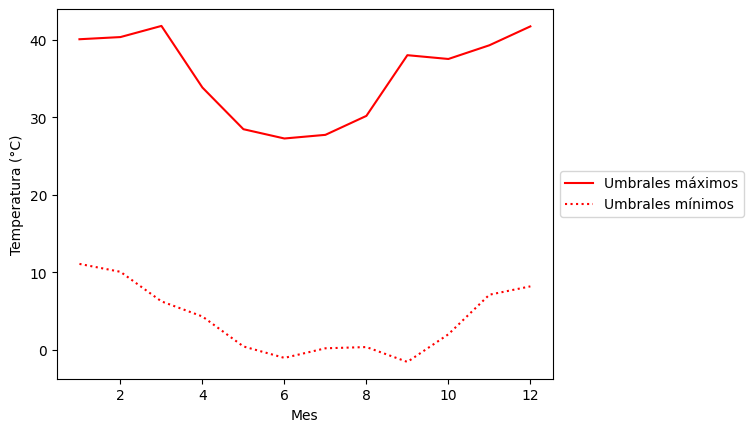

In [13]:

import matplotlib.pyplot as plt
x = [1,2,3,4,5,6,7,8,9,10,11,12]
y1= [i[1] for i in Finales ]
y11= [i[2] for i in Finales ]

plt.plot(x, y1, c="red",label="Umbrales máximos")
plt.plot(x, y11, c="red",ls = ':',label="Umbrales mínimos")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Mes')
plt.ylabel('Temperatura (°C)')
plt.show()